In [1]:
# import some library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import lightgbm as lgb
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# read data
df = pd.read_csv('../data/feature_importance_neg.csv', index_col=0)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [3]:
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
# Try dart

for i in [255]: # max_bin
    for l in [0.1]: # learning_late
        for m in [31, 50]: # num_leaves
            for v in ['gbdt']: # boosting
                
                # define and fit
                gbm = lgb.LGBMClassifier(
                    objective='multiclass',
                    device = 'gpu',
                    max_bin=i,
                    learning_rate=l,
                    num_leaves=m,
                    boosting=v
                )

                gbm.fit(
                    X_train, 
                    y_train,
                    eval_set=[(X_test, y_test)],
                    early_stopping_rounds=50,
                    verbose=False
                )

                print(gbm.score(X_test, y_test))
                print(
                    'max_bin: '+str(i),
                    'learning_late: '+str(l), 
                    'num_leaves: '+str(m), 
                    'boosting: '+str(v),
                )

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7446808510638298
max_bin: 255 learning_late: 0.1 num_leaves: 31 boosting: gbdt
0.7446808510638298
max_bin: 255 learning_late: 0.1 num_leaves: 50 boosting: gbdt


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Normalized confusion matrix
[[0.71 0.   0.29 0.  ]
 [0.07 0.5  0.   0.43]
 [0.13 0.   0.87 0.  ]
 [0.   0.29 0.   0.71]]


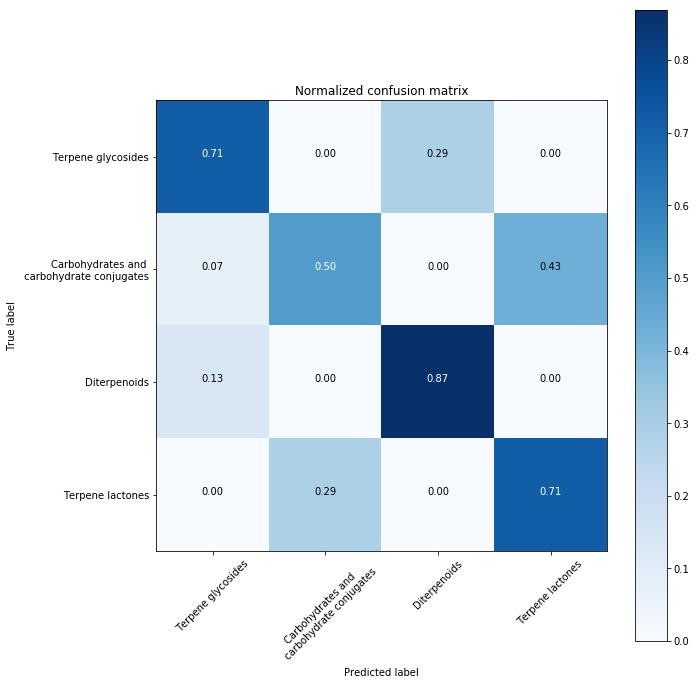

In [15]:
# set name list
class_names = list(df.Subclass.value_counts().index)
class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbm.predict(X_test))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()